In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import copy

C:\Users\nb5786-A\miniconda3\envs\maravelias\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Quick Nonlinear optimization to determine the best placement of linear regions

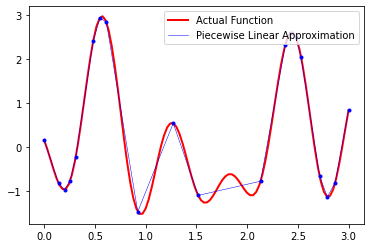

In [17]:
def func(x):
    return np.sin(3*x) + np.sin(10*x+2) + np.sin(7*x+4)

nRegions = 20

minX = 0
maxX = 3

xs = np.linspace(minX,maxX,100)
ys = func(xs)
plt.plot(xs,ys,"r",linewidth=2,label="Actual Function")

def optimizeRegions(xs):
    res = 200
    xs = np.insert(xs, 0, minX)
    xs = np.append(xs, maxX)
    xs = np.sort(xs)
    
    interpFunc = interp1d(xs,func(xs))
    
    err = sum([(func(x) - interpFunc(x))**2 for x in np.linspace(minX,maxX,res)])
    
    if min(xs) < minX:
        err += np.absolute(min(xs) - minX)
    if max(xs) > maxX:
        err += np.absolute(max(xs) - maxX)
    
    return err

xs = minimize(optimizeRegions,1.15*np.arctan(2*np.linspace(minX,maxX,nRegions-2)-maxX)+maxX/2).x
xs = np.insert(xs, 0, minX)
xs = np.append(xs, maxX)
xs = np.sort(xs)

plaXs = copy.deepcopy(xs)
plaYs = func(plaXs)
plt.plot(plaXs,plaYs,"b.")
plt.plot(plaXs,plaYs,"b",linewidth=0.5,label="Piecewise Linear Approximation")
plt.legend()

# Manual Version 
### (To demonstrate the concept)

$Maximize\left( y = \sum_{i \in I} W_i y_i \right)$

s.t. 

$\sum_{i \in I} W_i = 1$ : Weights must equal 1

$W_i \geq 0 \ \ \ \ \forall \ i \ \in \ I$ : All weights must be positive

$W_i \leq A_i$ : A weight must be zero if that region is not active

$\sum_{i \in I} A_i = 2$ : Precisely two regions should be active

$A_i \leq A_{i-1} + A_{i+1}$ : The two active regions must be neighbors

In [48]:
model = pyo.ConcreteModel()

model.I = pyo.Set(initialize=range(len(plaXs)))

model.W = pyo.Var(model.I, domain=pyo.NonNegativeReals)
model.A = pyo.Var(model.I, domain=pyo.Binary)

model.Objective = pyo.Objective(
    expr = sum([model.W[i] * plaYs[i] for i in model.I]),
    sense = pyo.maximize
)

model.weightSumConstr = pyo.Constraint(expr = sum([model.W[i] for i in model.I]) == 1)
    
def weightActivationConstr(m,i):
    return m.W[i] <= m.A[i]
model.weightActivationConstr = pyo.Constraint(model.I, rule= weightActivationConstr)
    
model.twoActivationConstr = pyo.Constraint(expr = sum([model.A[i] for i in model.I]) <= 2)

def neighborConstr(m,i):
    lhs = m.A[i]
    rhs = 0
    if (i-1) >= 0:
        rhs += m.A[i-1]
    if (i+1) < len(m.A):
        rhs += m.A[i+1]
            
    return lhs <= rhs
model.neighborConstr = pyo.Constraint(model.I, rule=neighborConstr)
    
pyo.SolverFactory('gurobi').solve(model)#.write()

print("\nWeight Value\tActivation Value\tX Value\t\tY Value")
for i in range(len(model.W)):
    print("W{} = {}\t{}\t\t\t{:.6f}\t{:.6f} {}".format(i,model.W[i](),model.A[i](),plaXs[i],plaYs[i],"***" if model.W[i]() == 1 else ""))


Weight Value	Activation Value	X Value		Y Value
W0 = 0.0	0.0			0.000000	0.152495 
W1 = 0.0	0.0			0.141392	-0.819185 
W2 = 0.0	0.0			0.200858	-0.964556 
W3 = 0.0	0.0			0.255399	-0.769458 
W4 = 0.0	0.0			0.311650	-0.216347 
W5 = 0.0	1.0			0.483576	2.409723 
W6 = 1.0	1.0			0.550512	2.936506 ***
W7 = 0.0	-0.0			0.613403	2.829787 
W8 = 0.0	-0.0			0.922461	-1.466906 
W9 = 0.0	-0.0			1.272283	0.541368 
W10 = 0.0	-0.0			1.517529	-1.097485 
W11 = 0.0	-0.0			2.133204	-0.774749 
W12 = 0.0	-0.0			2.376167	2.313903 
W13 = 0.0	-0.0			2.428249	2.592865 
W14 = 0.0	-0.0			2.478694	2.507898 
W15 = 0.0	-0.0			2.532154	2.045002 
W16 = 0.0	0.0			2.714588	-0.654369 
W17 = 0.0	0.0			2.791048	-1.129328 
W18 = 0.0	0.0			2.868440	-0.806470 
W19 = 0.0	0.0			3.000000	0.831193 


# Built-in Version

In [42]:
import pyomo.core as pyoc

In [54]:
model = pyo.ConcreteModel()

model.X = pyo.Var(domain=pyo.Reals, bounds=(minX,maxX))
model.Y = pyo.Var(domain=pyo.Reals)

model.FunctionEqualityConstraint = pyoc.Piecewise(
    model.Y,
    model.X,
    pw_pts = plaXs.tolist(), 
    f_rule = plaYs.tolist(), # Note that you could have passed "func" as an argument here
    pw_repn ='SOS2', #There are different options here. See documetation
    pw_constr_type = 'EQ' #Could have specified LB (Y >= func(X)) or UB (Y <= func(X))
)

model.Objective = pyo.Objective(
    expr = model.Y,
    sense = pyo.maximize
)

pyo.SolverFactory('gurobi').solve(model).write()

print("\nX Value: {:.6f}".format(model.X()))
print("Y Value: {:.6f}".format(model.Y()))

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x23
  Lower bound: 2.9365060024878753
  Upper bound: 2.9365060024878753
  Number of objectives: 1
  Number of constraints: 5
  Number of variables: 23
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 23
  Number of nonzeros: 62
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was so